# CH3G0

# Unraveling the Atomistic Structure of Solid-Fluid interfaces via Molecular Dynamics Simulations

In this computational experiment you will use **molecular dynamics simulations** to investigate the structure of a Solid-Fluid interface (modelled via two types of Lennard-Jones particles) at the atomistic level.

You will use the Python-based Jupyter Notebook framework, leveraging Statistical Mechanics to compute several structural features of this system.

This notebook outlines how to set up the MD simulation using the HOOMD-blue simulation package, and some tips on using the Atomic Simulation Environment (ASE) for handling atomic configurations.

You can find further help, features and options on the Manual pages:  
[HOOMD-blue page](https://hoomd-blue.readthedocs.io/en/stable/index.html)  
[ASE page](https://wiki.fysik.dtu.dk/ase/index.html)

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

### Content 

1. Import necessary libraries and initialise HOOMD
2. Set up the system: number of atoms, initial simulation box, initial structure 
3. Define interaction between particles: binary Lennard-Jones parameters, define cut off distance
4. Set up the MD simulation and the ensemble: set the integrator, temperature, pressure
5. Set the output format: output file and logged quantities
6. Perform the simulation: run()
7. Saving the atomic coordinates and visualising the system 
8. Analysing results

## 1. Import necessary libraries and initialise HOOMD

In [1]:
# Import the hoomd python package and the md component we will use to perform MD simulations.
import hoomd
import hoomd.md

import numpy as np
import matplotlib.pyplot as plt
import ase
from ase import io
from ase.visualize import view
import pytraj as pt
import nglview as nv
from python_stuff import save_config

We need to initialize the execution context to control where HOOMD will execute the simulation. We will run the simulations on the CPU (HOOMD also allows options for GPU, but we won't use them).

In [2]:
hoomd.context.initialize('--mode=cpu');

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 12/16/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


## 2. Set up the system: number of atoms, initial simulation box, initial structure

In [3]:
# Read the initial configuration...
pdb = io.read('initial_configuration.pdb')
pos = pdb.get_positions() # get the atomic positions from the .pdb file 
pos = pos.tolist() # re-format the positions array in a hoomd-friendly format
n_at = len(pos) # get the number of atoms from the .pdb file 

# Rename the atomic species. ASE won't read 'A' or 'B' particles, as these
# are not valid element symbols, but hoomd likes 'A' and 'B', so...
typ = []
for i in range (0,int(n_at/2)):
    typ.append('A')
for i in range (int(n_at/2),n_at):
    typ.append('B')

# Set the masses, all equal to 1 - a conversation about units...
ms = []
for i in range (0,int(n_at)):
    ms.append(1.0)

# Build the initial configuration for hoomd
initial_cell = hoomd.lattice.unitcell(N = n_at, a1 = pdb.cell[0], a2 = pdb.cell[1], a3 = pdb.cell[2], \
                dimensions=3, position = pos, type_name = typ, mass = ms);

system = hoomd.init.create_lattice(unitcell=initial_cell, n=1);

notice(2): Group "all" created containing 864 particles


It is useful to check parameters of the system: the following can be used to extract the types of atoms, number of atoms and the dimensions of the simulation box. It is also usually a good idea to inspect the initial system visually - check section **7: Saving the atomic coordinates and visualising the system** for tips on how to do this.

In [4]:
print(system.particles.types)
print(system.particles.pdata)
print(system.box)

Particle types: ['A', 'B']
ParticleData: 864 particles
Box: Lx=15.274 Ly=15.274 Lz=50.0 xy=0.0 xz=0.0 yz=0.0 dimensions=3


Now it's time to have a look at our system. Due to some technicalities, we had to write a function, `save_config`, which takes care of HOOMD internal formats so that we can display it via [nglview](https://github.com/arose/nglview). There's more information in **section 7** about visualisation, check that out!

In [5]:
current_config = save_config(system)
ase.io.write("system.pdb", current_config)

p_traj = pt.load('system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view.add_unitcell()
p_view

NGLWidget()

## 3. Define interaction between particles: binary Lennard-Jones parameters, define cut off distance

To be able to calculate the potential, atomic distances will have to be calculated first. Most simulation codes use some kind of method to keep track of pairs of atoms, and create a neighbour list. We can choose from different methods implemented in HOOMD, but for the present system, the so called cell method will perform the best, so lets set this one:

In [6]:
nl = hoomd.md.nlist.cell()

The next step is to initialise the Lennard-Jones potential, and set the cutoff distance, ``r_cut``. If two atoms are further away from each other than this distance, their pair energy contribution is zero. To allow sufficent distance for interaction, do not set ``r_cut`` to be smaller than 2.5. Note: HOOMD uses the minimum image convention, thus the interaction sphere defined by the cutoff distance can never span beyond the simulation box. (Thus, ``r_cut`` has to be smaller than half of any of the box lengths (``Lx, Ly, Lz``) at **any point** during the simulation, otherwise you'll receive an error message.)

In [7]:
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) # define potential

Set the Lennard-Jones interaction parameters, $\sigma$ and $\epsilon$, for all combinations of pair types. Since these parameters also determine the energy and distance scale of the simulation (temperature is in $kT/\epsilon$ units, and pressure is in $P\sigma^3/\epsilon$ units), set $\sigma=1.0$ and $\epsilon=1.0$ to the ``'A','A'`` pair, so no further unit conversion will be necessary.

In [8]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('A', 'B', epsilon=2.0, sigma=2.0)
lj.pair_coeff.set('B', 'B', epsilon=0.1, sigma=0.8)

## 4. Set up the MD simulation and the ensemble: set the integrator and temperature

First, we need to tell the simulation engine whether all particles are to be treated by the same during the molecular dynamics steps (e.g. the same integrator to be used...etc.), or we use different parts of the system to be treated differently. In the current system we want to make sure that the solid phase is preserved, so we will keep all 'A' type atoms fixed, so we will apply the integrator only the 'B' type atoms forming the fluid phase.

In [9]:
all = hoomd.group.all()
typeB = hoomd.group.type('B')

notice(2): Group "type B" created containing 432 particles


To integrate the system forward in time, an integration mode must be set. We will used the ``mode_standard``, where at each timestep, all of the specified forces are evaluated and used in moving the system forward to the next timestep.
This is where we also set the length of one MD timestep the integrator will use.

In [10]:
hoomd.md.integrate.mode_standard(dt=0.005);

There are a couple of further options we have to set, depending on whether we want to keep the volume or the pressure constant, how we want to set the temperature or pressure...etc. These are all set through the integrator. In HOOMD **only one** integration mode can be active at a time, and the last ``integrate`` command is the one that will take effect. In the current work, we have fixed solid phase and hence we will keep the volume fixed during the simulation. 

<b> ($N$,$V$,$T$) simulation using the Langevin thermostat.</b>
    ``kT`` is the temperature of the thermostat in energy units, ``seed`` is random number seed for initialising the random forces to be applied on the atoms. Integrator applied to the group of 'B' atoms only.

In [11]:
nvt = hoomd.md.integrate.langevin(group=typeB, kT=0.8, seed=10)

notice(2): integrate.langevin/bd is using specified gamma values


**A note on temperature**
Since we are working with the Lennard-Jones potential and hence working in Lennard-Jones units, temperature values sensible in this system will not resemble numerical values you would expect for a common material. 

With $\sigma$ and $\epsilon$ parameters both being set to 1.0, and considering the density our 'B' particles, the LJ model is a fluid above kT=0.6 (might form separate liquid and gas phases below kT=1.2, but mind that the gas phase in the our simulation box might just be an empty space, like a bubble.) Of course the phase transition temperature will depend on the LJ parameters you choose, but this is a good starting point to start experimneting with your system. **Do not forget to comment on your final choice of parameters and your findings if you have explored multiple values!** 


## 5. Set the output format: output file and logged quantities

What quantities should be collected, how often, and where they should be saved during the MD simulation?

A number of quantities are calculated during a simulation, and these can be logged so we can check and analyse them later. A few example of useful quantities are below, you can choose which ones to include. The log file is a text file, with each column corresponding to the ``quantities`` defined, in the same order. Output data is written to the file line by line at every ``period`` timestep.

In [12]:
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

In [13]:
t_dump = 100

hoomd.analyze.log(filename="log-output.4.log",
                  quantities=quantities,
                  period=t_dump,
                  overwrite=True) # keep appending the existing file

In [14]:
d = hoomd.dump.dcd("dump.dcd", period=100, group=all, overwrite=True, unwrap_full=False);

## 6. Perform the simulation: run()

When all is set, you can start the actual molecular dynamics simulation. The following simple command performs ``10000`` MD timesteps with the parameters set so far.

In [15]:
n_tsteps = 10000
hoomd.run(n_tsteps)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 864
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:02 | Step 10000 / 10000 | TPS 5535.48 | ETA 00:00:00
Average TPS: 5533.38
---------
-- Neighborlist stats:
785 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 12 / n_neigh_avg: 4.63657
shortest rebuild period: 8
-- Cell list stats:
Dimension: 5, 5, 17
n_min    : 0 / n_max: 6 / n_avg: 2.03294
** run complete **


``10000`` steps should take less than a minute. If you perform the ``hoomd.run()`` command again, the simulation will continue from the last configuration available. Between ``hoomd.run()`` commands you can (and are strongly encouraged) to check the status of the simulation (e.g. how the potential energy, the temperature...etc. changes. Do they fluctuate widely or converged around a value?). 

## 7. Saving the atomic coordinates and visualising the system 

HOOMD uses its own binary file format to save configurations file, which would be difficult to handle without additional separate programs, so we will make use of the Atomic Simulation Environment (ASE) to save configurations and analyse them. 
The short ``save_config`` function (in the python_stuff.py) extracts the simulation box parameters and the atomic coordinates from the hoomd ``system`` we have defined, and creates an atoms object from it. 

**Note:** ASE expects real atomic symbols as atom types, thus ``A`` and ``B`` will not work. You are free to choose which elements are to represent your LJ particles (the defaulyt in the function are carbon and fluorine), it will only effect the visualisation and how you refer to the atoms during the analysis code. 

You can convert the current state of the ``system`` to an atoms object, you can write this to a text file.

In [16]:
ase.io.write("system.pdb", current_config)

Now let's have a look at the trajectory...

In [17]:
p_traj = pt.load('dump.dcd', top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget(max_frame=99)

## 8. Analysing results

Saved quantities can be e.g. read from the produced logfile, and plotted as required. Keep in mind that the order of the quantities is what you have defined at the point of creating the log, so can be different from the example below (the first column is always the timestep).

In [18]:
data = np.genfromtxt(fname='log-output.4.log', skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']
# Note that the first column [index 0] will contain the time. 
# For instance, data[:,7] corresponds to the temperature data

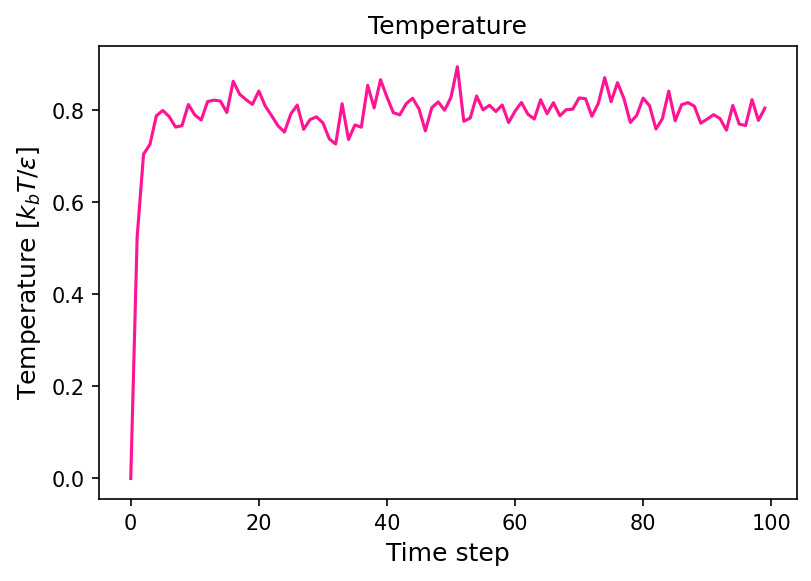

In [19]:
fig=plt.figure(num=None,figsize=(6,4),dpi=150,facecolor='w',edgecolor='k')

plt.plot(data[:,7], color='deeppink')
plt.title("Temperature")
# # plt.xlim(0.15)
# plt.ylim(0,0.2)
plt.xlabel('Time step',fontsize=12)
plt.ylabel('Temperature [$k_b T / \epsilon$]',fontsize=12)
plt.show()

**Tips on handling the ASE atoms object**   
Below are a couple of examples on how to extract information from the atoms object.
These are useful when dealing with a single .pdb file.

In [20]:
at_configuration = ase.io.read("system.pdb") # read atoms objects from file
box=at_configuration.get_cell() # simulation box parameters (3*3 matrix)
vol=at_configuration.get_volume() # volume of the simulation box
pos=at_configuration.get_positions() # atomic coordinates
N=len(at_configuration) # number of atoms
at_type=at_configuration.get_chemical_symbols() # atom_type of each atom

ASE provides several tools to analyse structural properties of configurations, if necessary modules are loaded (`from ase.geometry.analysis import Analysis`) e.g. to calculate radial distribution functions. For further help on how to use these features, check the manual.

#### Tips on how to access a specific frame within the MD trajectory
Below are a couple of examples on how to extract information from the MD trajectory, which
we have previosuly loaded in `p_traj` via `p_traj = pt.load('dump.dcd', top='system.pdb')`.
These are useful when dealing with the MD trajectory as a whole.

In [21]:
# The MD trajectory as been loaded above in p_traj
p_traj

pytraj.Trajectory, 100 frames: 
Size: 0.001931 (GB)
<Topology: 864 atoms, 864 residues, 864 mols, PBC with box type = ortho>
           

In [22]:
# To access the third frame within the MD trajectory:
frame = p_traj[2]
frame

<Frame with 864 atoms>

In [23]:
# To access all the atomic positions in that frame
frame.xyz

array([[ 0.        ,  0.        , 11.        ],
       [ 1.273     ,  1.273     , 12.80000019],
       [ 0.        ,  0.        , 14.60000038],
       ...,
       [-1.25316644, -2.43074512, -1.55673146],
       [-2.22873378, -2.58494902,  0.96821594],
       [-1.47906983, -0.40632272,  2.54463267]])

In [24]:
# To access the z-coordinate of the 16-th atom within the 65-th frame within the MD trajectory:
p_traj[64].xyz[15,2]

16.399999618530273